## Data Preprocessing

This stage includes some data manipulations

In [3]:
import random
import re
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from typing import List, Dict, Tuple, Set
import time
from tqdm import tqdm
import os
import json
import copy

import Bio.SeqIO
from Bio import Entrez

In [5]:
ORIGINAL_DATA_PATH = "salmonella-enterica.reads.fna"
RESISTANT_DATA_PATH = "salmonella-enterica-variant.reads.fna"

KMERS_DICTS_PATH = 'kmers_values_clear'

In [7]:
%%time
data = {}
data['orig'] = list(Bio.SeqIO.parse(ORIGINAL_DATA_PATH, "fasta"))
data['resist'] = list(Bio.SeqIO.parse(RESISTANT_DATA_PATH, "fasta"))
len(data['orig']), len(data['resist'])

CPU times: user 12.8 s, sys: 599 ms, total: 13.4 s
Wall time: 13.6 s


(1993167, 1993167)

In [8]:
%%time

# transform into usual python types (set(str))
for key, value in data.items():
    data[key] = set([str(read.seq) for read in value])
len(data['orig']), len(data['resist'])

CPU times: user 1.31 s, sys: 225 ms, total: 1.54 s
Wall time: 1.56 s


(1943902, 1944055)

There is a significant part of repetitions in data. It is possibly "second circle" of reading. Anyway, it seems not informative. We will try to work without repetitions.

In [10]:
# count reads lengths to avoid statistical mistakes
read_lengths = {key: [] for key in data}
for key, value in data.items():
    read_lengths[key] = [len(read) for read in random.sample(list(data[key]), 10000)]
    print(min(read_lengths[key]), max(read_lengths[key]))

250 250
250 250


## Hyperparameters search

### k for k-mers search

The main hyperparameter to be found is k for k-mer. Too small k will generate a high frequency of k-mers because they will no longer be unique parts of the genome. Too large k, on the other hand, will produce too low a frequency due to the small number of reads overlapping of that length.\It is also worth noting that from a computational point of view, small k's are slightly more favourable, both in terms of time and memory.

In [14]:
class KSearcher:
    def __init__(self, num_reads=1_944_055, size_read=250, true_genome_size=4_857_450):
        self.L = size_read
        self.N = num_reads
        # multiplying G by 2 because we don't have any infornation about right/reverse writing
        self.G = 2*true_genome_size
        self.eta = 0.01
        self.reverse = {'A': 'T', 'T': 'A', 'C': 'G', 'G': 'C'}
        self.bacteria2index = {'orig': 0, 'resist': 1}

    def reverse_dnk(self, seq: str) -> str:
        reversed = ''
        for nucl in seq:
            reversed += self.reverse[nucl]
        return reversed

    def count_kmers(self, full_reads: Dict[str, set[str]], k: int, return_values_only=False) -> Dict[str, List[int]]:
        dict_kmers = {}
        for bacteria, reads in full_reads.items():
            for read in reads:
                for i in range(self.L-k+1):
                    k_mer = read[i:i+k]
                    if k_mer not in dict_kmers:
                        dict_kmers[k_mer] = [0, 0]
                    dict_kmers[k_mer][self.bacteria2index[bacteria]] += 1
        if return_values_only:
            return list(dict_kmers.values())
        return dict_kmers

    def count_approx_distribution(self, k):
        E_Ck = self.N * (self.L - k + 1) / (self.G - self.L + 1)
        p0 = (1-self.eta)**k
        return E_Ck, p0

    def count_kmers_number(self, k):
        return int(self.N * (self.L - k + 1))

In [255]:
# We will count k-mers distributions with several k

default_searcher = KSearcher()
bacteria2len = {'orig': len(data['orig']), 'resist': len(data['resist'])}

for k in tqdm(range(11, 19, 2)):
    approx_distrs = {'orig': [], 'resist': []}
    start_time = time.time()
    kmers_values = default_searcher.count_kmers(data, k=k, return_values_only=True)
    for key in data.keys():
        searcher = KSearcher(num_reads=bacteria2len[key])
        approx_distrs[key] = list(searcher.count_approx_distribution(k))
    with open(os.path.join(KMERS_DICTS_PATH, str(k) + '.json'), 'w') as f:
        json.dump({'kmers_values': kmers_values, 'theor_distr': list(approx_distrs.values()), 'counting_time': time.time()-start_time}, f)

100%|████████████████████████████████████████████| 4/4 [57:09<00:00, 857.28s/it]


In [202]:
for k in tqdm(range(19, 27, 2)):
    approx_distrs = {'orig': [], 'resist': []}
    start_time = time.time()
    kmers_values = default_searcher.count_kmers(data, k=k, return_values_only=True)
    for key in data.keys():
        searcher = KSearcher(num_reads=bacteria2len[key])
        approx_distrs[key] = list(searcher.count_approx_distribution(k))
    with open(os.path.join(KMERS_DICTS_PATH, str(k) + '.json'), 'w') as f:
        json.dump({'kmers_values': kmers_values, 'theor_distr': list(approx_distrs.values()), 'counting_time': time.time()-start_time}, f)

100%|████████████████████████████████████████████| 4/4 [48:17<00:00, 724.27s/it]


In [334]:
index2name = {0: 'original', 1: 'resistant'}
def vizualize(k: int, limits: Tuple[int, int]=(8,150)):
    '''
    This finction vizualizes both empirical and theoretical distributions. Prints number of kmers that are preliminarily valid.
    '''
    with open(os.path.join(KMERS_DICTS_PATH, str(k) + '.json')) as f:
        full_info = json.load(f)
    kmers_values = [[value[i] for value in full_info['kmers_values'] if limits[0]<value[i]<limits[1]] for i in range(2)]
    theor_params = full_info['theor_distr']
    fig, ax = plt.subplots(1,2, figsize=(10,4))
    fig.suptitle(f'Distributions for {k}')
    for i in range(2):
        treor_ditrib = np.random.poisson(theor_params[i][0], len(kmers_values[i]))
        #treor_ditrib = np.random.binomial(theor_params[i][0], theor_params[i][1], len(kmers_values[i]))
        print(f'{index2name[i]} bactria: preliminarily valid kmers number = {len(kmers_values[i])}')
        sns.histplot({'theoretical': treor_ditrib, 'empirical': kmers_values[i]}, ax=ax[i], bins=70)
        ax[i].set_title(f'{index2name[i]} bacteria')
    plt.show()
    return

original bactria: preliminarily valid kmers number = 1971788
resistant bactria: preliminarily valid kmers number = 1972778


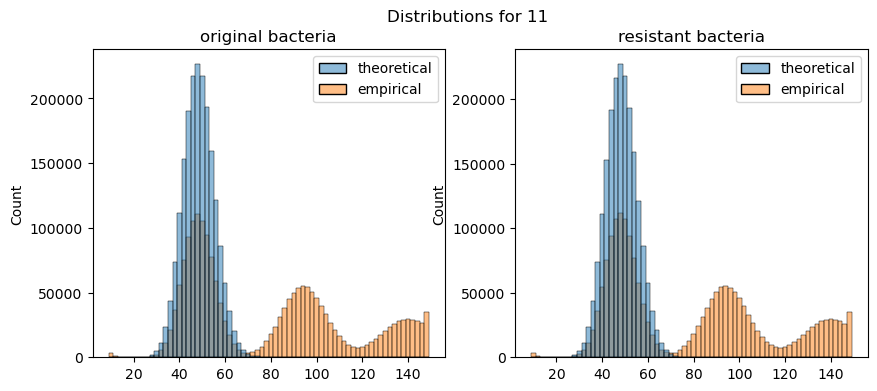

In [338]:
vizualize(11)

original bactria: preliminarily valid kmers number = 9574756
resistant bactria: preliminarily valid kmers number = 9574559


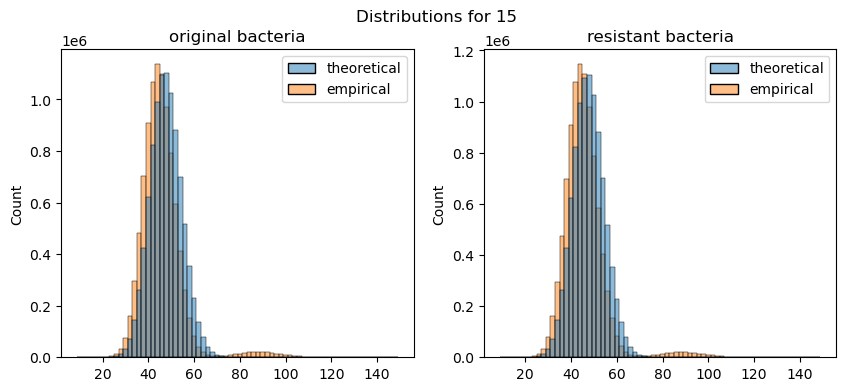

In [341]:
vizualize(15)

original bactria: preliminarily valid kmers number = 9750275
resistant bactria: preliminarily valid kmers number = 9750141


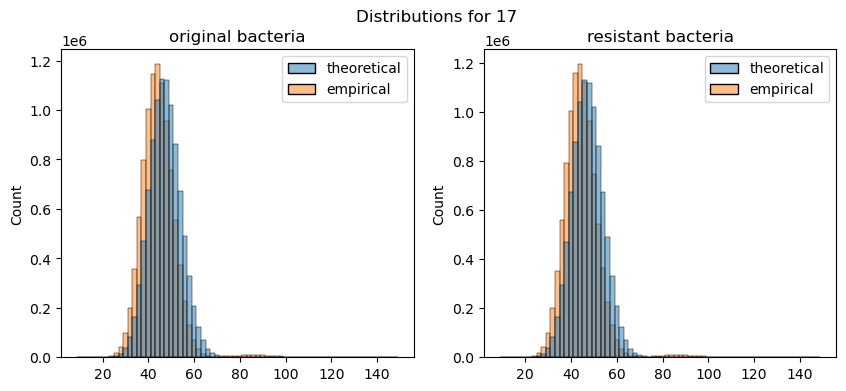

In [340]:
vizualize(17)

original bactria: preliminarily valid kmers number = 9792747
resistant bactria: preliminarily valid kmers number = 9792719


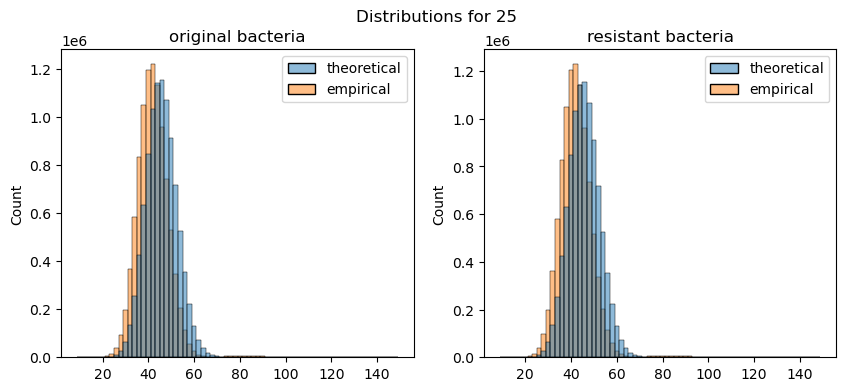

In [342]:
vizualize(25)

As we can see, the distribution starting with 17 is almost constant. At a value of 15, there is still a small number of data logically to the right of the theoretical values. However, as k increases, bias accumulates. Taking into account all factors, we take **k=17**.

### min & max thresholds search

As we know, there are errors in the data. There can also be k-mers that occur too often in the genome (too many genes contain this particular sequence of nucleotides). Both of these types - too frequent and too rare nucleotides - are not informative. Therefore, it is necessary to find the minimum and maximum number of k-mer threshholds.\
We will go the practical bootstrap way: we will generate samples from the theoretical distribution and look at the minimum and maximum. Then we will construct confidence intervals and take their left and right points for the minimum and maximum, respectively.\
Since the difference in the number of reads between the genomes of the resistant and original bacteria is relatively small, we will ignore it and take the average in order to save computational resources.

In [347]:
class ThresholdSearcher:
    def __init__(self, k):
        self.k = k
        self.distib_searcher = KSearcher(num_reads = np.mean([len(data['orig']), len(data['resist'])]))
        self.beta = 0.95
        self.sample_size = 10_000

    def __collect_values(self, batch_size=10**6, kmers_number = 10**6):
        theor_params = self.distib_searcher.count_approx_distribution(self.k)
        kmers_number = 10**6
        mins, maxs = [], []
        for num in tqdm(range(self.sample_size)):
            current_min, current_max = np.inf, -np.inf
            if kmers_number < 10**7:
                # sample = np.random.binomial(theor_params[0], theor_params[1], kmers_number)
                sample = np.random.poisson(theor_params[0], kmers_number)
                current_min = min(sample)
                current_max = max(sample)
            # we can find min and max using batches, if number of sample can be too large for RAM
            else:
                current_min, current_max = np.inf, -np.inf
                for batch in range(kmers_number//batch_size):
                    sample = np.random.binomial(theor_params[0], theor_params[1], batch_size)
            mins.append(current_min)
            maxs.append(current_max)
        return mins, maxs

    def call(self):
        mins_sample, maxs_sample = self.__collect_values()
        left_quantile = (1-self.beta) / 2
        right_quantile = (1+self.beta) / 2
        min_limit = np.quantile(mins_sample, left_quantile)
        max_limit = np.quantile(maxs_sample, right_quantile)
        return min_limit, max_limit

In [349]:
%%time
min_limit, max_limit = ThresholdSearcher(17).call()
min_limit, max_limit

100%|█████████████████████████████████████| 10000/10000 [14:07<00:00, 11.80it/s]

CPU times: user 13min 56s, sys: 9.17 s, total: 14min 5s
Wall time: 14min 7s


(15.0, 89.0)

Result thresholds are:
Min threshhold = **15**; max threshhold = **100**.

## SNPs search

At this stage, we suppose that we have clear data without errors. Consequently, we can compare *kmers* in original and resistant bacteria. Mutated ones have to be in resistant bacteria. At their places there are original kmers that are not in resistant kmers.

In detail:
 - Firstly, we find *candidates* - kmers that are in one (e.g. resistant) bacteria, but not in another (e.g. original).
 - Secondly, we build possible sequences of *candidates*, as one mutated nucliotide has to born $\approx$ k such kmers.
 - Thirdly, we try to find matches between resistant and original candidates using count vectorizing (counting places in strings with different nucleotides)

In [352]:
class MutationPlaceSearcher():
    def __init__(self, k):
        self.k = k
        self.recursive_depth = k
        self.k_searcher = KSearcher()
        self.index2bacteria = {0: 'orig', 1: 'resist'}
        self.min_threshold = 15
        self.max_threshold = 89

    def __find_candidates(self, full_reads: Dict[str, List[int]]) -> Dict[str, Set[str]]:
        kmers_dicts = self.k_searcher.count_kmers(full_reads, k=self.k, return_values_only=False)
        result = {key: set() for key in full_reads}
        for kmer, kmer_count in kmers_dicts.items():
            if min(kmer_count) == 0 and self.min_threshold < max(kmer_count) < self.max_threshold:
                result[self.index2bacteria[np.argmax(kmer_count)]].add(kmer)
        return result

    def __make_sequences(self, candidates: Set[str]) -> List[Tuple[str, str]]:
        sequences = copy.deepcopy(candidates)
        final_sequences = []
        for start_seq in sequences:
            is_cand = True
            cand = start_seq
            sequence = cand
            for rec_depth in range(self.recursive_depth):
                flag_14 = False
                var13 = None
                for next_cand in sequences:
                    if next_cand == start_seq:
                        continue
                    if cand[-self.k+1:] == next_cand[:self.k-1]:
                        flag_14 = True
                        sequence += next_cand[-1]
                        break
                    elif cand[-self.k+2:] == next_cand[:self.k-1]:
                        var13 = next_cand
                if not flag_14:
                    if var13:
                        next_cand = var13
                        sequence += next_cand[-2:]
                    else:
                        is_cand = False
                        break
                cand = next_cand
            final_sequences.append(sequence)
        final_sequences = sorted(final_sequences, key=lambda s: s[::-1])
        prev = 'biology'
        for seq in copy.deepcopy(final_sequences):
            if prev in seq:
                final_sequences.remove(prev)
            prev = seq
        return final_sequences

    def distance(self, kmer1: str, kmer2: str) -> int:
        dist = 0
        dif_places = []
        if len(kmer1) != len(kmer2):
            raise ValueError('distance can be counted only for sequences of equal length')
        for i, symb1 in enumerate(kmer1):
            if symb1 != kmer2[i]:
                dist += 1
                dif_places.append(i)
        return dist, dif_places

    def __find_nearest_neighbors(self, sequences_orig: Set[str], sequences_resist: Set[str], threshold:int=None, topn_cands:int = 2) -> List[Tuple[str, str, int]]:
        if not threshold:
            threshold=self.k//3
        result = []
        pairs = {}
        for seq_orig in sequences_orig:
            pairs[seq_orig] = []
            for seq_res in sequences_resist:
                min_distance = self.k * 2
                min_places = []
                if len(seq_res) > len(seq_orig):
                    long, short = seq_res, seq_orig
                else:
                    short, long = seq_res, seq_orig
                for start_symb in range(len(long)-len(short)+1):
                    dist, dif_places = self.distance(long[start_symb : start_symb + len(short)], short)
                    if dist < min_distance:
                        min_distance = dist
                        min_places = dif_places
                if min_distance < threshold:
                    pairs[seq_orig].append((seq_res, min_distance, min_places))

            pairs[seq_orig] = sorted(pairs[seq_orig], key=lambda x: x[1])[:topn_cands]
            result.extend([(seq_orig, elem[0], elem[1], elem[2]) for elem in pairs[seq_orig]])
        return result

    def for_test(self, full_reads: Dict[str, List[int]]):
        candidates = self.__find_candidates(full_reads)
        sequences = {type_bacteria: self.__make_sequences(cands) for type_bacteria, cands in candidates.items()}
        return sequences
    
    def postprocess(self, sequences: List[str], full_reads: Dict[str, List[int]], length:int=100) -> [Tuple[str, str]]:
        '''
        finds reads with given sequences and outputs subsequences of length {length}
        '''
        result = {}
        for i, seq in enumerate(sequences):
            type_bacteria = self.index2bacteria[i]
            need2add = length - len(seq)
            for read in full_reads[type_bacteria]:
                if seq in read:
                    start_seq_index = read.find(seq)
                    left_limit = max(start_seq_index - need2add//2, 0)
                    result[type_bacteria] = read[left_limit:left_limit+need2add]
        return result

    def call(self, full_reads: Dict[str, Set[str]]) -> Tuple[str, str, int, List[int]]:
        candidates = self.__find_candidates(full_reads)
        sequences = {type_bacteria: self.__make_sequences(cands) for type_bacteria, cands in candidates.items()}
        pairs = self.__find_nearest_neighbors(sequences[self.index2bacteria[0]], sequences[self.index2bacteria[1]])
        for i, pair in enumerate(pairs):
            pairs[i] = (pair[1], pair[0], pair[2], pair[3])
            if len(pair[0]) < len(pair[1]):
                pairs[i] += (0, )
            else:
                pairs[i] += (1, )
        return pairs

In [354]:
%%time
mutate_searcher = MutationPlaceSearcher(17)
pairs17 = mutate_searcher.call(data)
result = '\n\n'.join([f'Sequence with mutation: {pair[0]}\nAnalogical sequence without mutation: {pair[1]}\nNumber of mutated nucleotides: {pair[2]}\nIndexes of mutated nucliotides: {pair[3]} in {pair[4]+1} sequence' for pair in pairs17])
print(result)

Sequence with mutation: AGGTTTAACAACCCGTCCCCTCGCCCAGAAGCTA
Analogical sequence without mutation: AGGTTTAACAACCCGTAAACTCGCCCAGAAGCTA
Number of mutated nucleotides: 3
Indexes of mutated nucliotides: [16, 17, 18] in 2 sequence

Sequence with mutation: CTAGCTTCTGGGCGAGGGGACGGGTTGTTAAACC
Analogical sequence without mutation: CTAGCTTCTGGGCGAGTTTACGGGTTGTTAAACC
Number of mutated nucleotides: 3
Indexes of mutated nucliotides: [16, 17, 18] in 2 sequence

Sequence with mutation: GGTTTAACAACCCGTCCCCTCGCCCAGAAGCTAG
Analogical sequence without mutation: GGTTTAACAACCCGTAAACTCGCCCAGAAGCTAG
Number of mutated nucleotides: 3
Indexes of mutated nucliotides: [15, 16, 17] in 2 sequence

Sequence with mutation: TAGCTTCTGGGCGAGGGGACGGGTTGTTAAACCT
Analogical sequence without mutation: TAGCTTCTGGGCGAGTTTACGGGTTGTTAAACCT
Number of mutated nucleotides: 3
Indexes of mutated nucliotides: [15, 16, 17] in 2 sequence
CPU times: user 3min 55s, sys: 50.9 s, total: 4min 46s
Wall time: 4min 57s


*Two last sequences are just parts of two first sequences. It can be postprocessed.*

In [243]:
%%time
mutate_searcher = MutationPlaceSearcher(17)
mutate_searcher.postprocess(['AGGTTTAACAACCCGTAAACTCGCCCAGAAGCTA', 'AGGTTTAACAACCCGTCCCCTCGCCCAGAAGCTA'], data)

CPU times: user 2.18 s, sys: 7.48 ms, total: 2.19 s
Wall time: 2.2 s


{'orig': 'CGCATTAGAGCTGCTTAATGAGGTCGGAATCGAAGGTTTAACAACCCGTAAACTCGCCCAGAAGCT',
 'resist': 'CGCATTAGAGCTGCTTAATGAGGTCGGAATCGAAGGTTTAACAACCCGTCCCCTCGCCCAGAAGCT'}

In [330]:
mutate_searcher.postprocess(['CTAGCTTCTGGGCGAGTTTACGGGTTGTTAAACC', 'CTAGCTTCTGGGCGAGGGGACGGGTTGTTAAACC'], data)

{'orig': 'TTACATGCCAATACAATGTAGGCTGCTCTACACCTAGCTTCTGGGCGAGTTTACGGGTTGTTAAAC',
 'resist': 'TTACATGCCAATACAATGTAGGCTGCTCTACACCTAGCTTCTGGGCGAGGGGACGGGTTGTTAAAC'}

## Test

Let's test the algorithm on the same true genome. Let's modify a random kmer and try to find it with the same hyperparameters.

In [245]:
test_index_read = random.choice(range(len(data['orig'])))
test_read = list(data['orig'])[test_index_read]
test_index_nucl = random.choice(range(250))
test_read[test_index_nucl:test_index_nucl+2], test_index_nucl

('CA', 142)

In [247]:
test_orig_kmer = test_read[test_index_nucl - 8 : test_index_nucl + 9]
test_resist_read = test_read[:test_index_nucl] + 'GG' + test_read[test_index_nucl + 2:]
test_resist_kmer = test_resist_read[test_index_nucl - 8 : test_index_nucl + 9]
test_orig_kmer, test_resist_kmer

('TTCCCGTTCATCTGAAA', 'TTCCCGTTGGTCTGAAA')

In [251]:
k=17
changed = []
outs = 0
data_test = {'orig': data['orig'], 'resist': set()}
resist_temp = list(data['orig'])
for j, read in enumerate(list(data['orig'])):
    for i in range(250-17+1):
        k_mer = read[i:i+k]
        if k_mer == test_orig_kmer:
            changed.append(j)
            resist_temp[j] = read[:i] + test_resist_kmer + read[i+k:]
data_test['resist'] = set(resist_temp)

In [355]:
%%time
mutate_searcher = MutationPlaceSearcher(17)
pairs17_test = mutate_searcher.call(data_test)

result = '\n\n'.join([f'Sequence with mutation: {pair[0]}\nAnalogical sequence without mutation: {pair[1]}\nNumber of mutated nucleotides: {pair[2]}\nIndexes of mutated nucliotides: {pair[3]} in {pair[4]+1} sequence' for pair in pairs17_test])
print(result)

Sequence with mutation: CTGGCCCATTCCCGTTGGTCTGAAAAAAGGCATT
Analogical sequence without mutation: TTCCCGTTCATCTGAAA
Number of mutated nucleotides: 2
Indexes of mutated nucliotides: [8, 9] in 1 sequence
CPU times: user 3min 29s, sys: 1.37 s, total: 3min 31s
Wall time: 3min 31s


In [358]:
test_orig_kmer in pairs17_test[0][1], test_resist_kmer in pairs17_test[0][0]

(True, True)